# XGBoost classifier

### Training model on complete dataset, i.e., without removing collinear features.

In [1]:
#Importing all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.options.mode.chained_assignment= None

import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

C:\Users\hmitt\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#Providing dataset filepath

root='datasets/'

In [3]:
#Reading the final dataset pickle file into a dataframe.

dataframe = pd.read_pickle (root + 'final_feature_data.pkl')
dataframe.head()

,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,...,total_reorders_by_user,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.900000,1.400000,17.593750,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
1,1,10258,9.0,8.0,0.888889,3.333333,19.562500,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
3,1,12427,10.0,9.0,0.900000,3.300000,17.593750,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
4,1,13032,3.0,2.0,0.666667,6.333333,21.671875,10.0,1.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667


In [4]:
# Function to reduce memory of the data frame
def reduce_mem(df):
    
    st_mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage of the dataframe is :",st_mem_usg,"MB")
    
    for column in df.columns:
        if df[column].dtypes in ["int64", "int32", "int16"]:
            
            colMin = df[column].min()
            colMax = df[column].max()
            
            if colMin > np.iinfo(np.int8).min and colMax < np.iinfo(np.int8).max:
                df[column] = df[column].astype(np.int8)
            
            elif colMin > np.iinfo(np.int16).min and colMax < np.iinfo(np.int16).max:
                df[column] = df[column].astype(np.int16)
            
            elif colMin > np.iinfo(np.int32).min and colMax < np.iinfo(np.int32).max:
                df[column] = df[column].astype(np.int32)
        
        if df[column].dtypes in ["float64", "float32"]:
            
            colMin = df[column].min()
            colMax = df[column].max()
            
            if colMin > np.finfo(np.float16).min and colMax < np.finfo(np.float16).max:
                df[column] = df[column].astype(np.float16)
            
            elif colMin > np.finfo(np.float32).min and colMax < np.finfo(np.float32).max:
                df[column] = df[column].astype(np.float32)
    
    print("Memory usage total")
    mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage: ",mem_usg," MB")
    print("Size reduced by ",100*mem_usg/st_mem_usg,"%")
    
    return df

In [5]:
#Memory consumption of dataframe.

dataframe.memory_usage().sum() / 1024**2 

4380.480062484741

In [6]:
#Reducing dataframe memory consumption for storage management.

dataframe = reduce_mem(dataframe)

Memory usage of the dataframe is : 4380.480062484741 MB
Memory usage total
Memory usage:  1309.2947788238525  MB
Size reduced by  29.88929889298893 %


In [7]:
dataframe

,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,...,total_reorders_by_user,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,...,41.0,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504
1,1,10258,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,...,41.0,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,41.0,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504
3,1,12427,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,...,41.0,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504
4,1,13032,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,...,41.0,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,206209,43961,3.0,2.0,0.666504,8.000000,23.328125,12.0,1.0,0.0,...,61.0,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336
8474657,206209,44325,1.0,0.0,0.000000,8.000000,9.000000,7.0,0.0,0.0,...,61.0,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336
8474658,206209,48370,1.0,0.0,0.000000,8.000000,30.000000,11.0,0.0,0.0,...,61.0,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336
8474659,206209,48697,1.0,0.0,0.000000,6.000000,9.000000,7.0,0.0,0.0,...,61.0,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336


In [8]:
dataframe['order_diff'] = dataframe.order_number - dataframe.product_last_bought_order
dataframe

,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,...,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,1,196,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
1,1,10258,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,6.0
3,1,12427,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
4,1,13032,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,206209,43961,3.0,2.0,0.666504,8.000000,23.328125,12.0,1.0,0.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,2.0
8474657,206209,44325,1.0,0.0,0.000000,8.000000,9.000000,7.0,0.0,0.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,7.0
8474658,206209,48370,1.0,0.0,0.000000,8.000000,30.000000,11.0,0.0,0.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,3.0
8474659,206209,48697,1.0,0.0,0.000000,6.000000,9.000000,7.0,0.0,0.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,7.0


In [9]:
dataframe.drop(['user_id', 'product_id'], axis = 1, inplace = True)
dataframe

,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,...,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
1,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
2,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,6.0
3,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
4,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,3.0,2.0,0.666504,8.000000,23.328125,12.0,1.0,0.0,0.0,14.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,2.0
8474657,1.0,0.0,0.000000,8.000000,9.000000,7.0,0.0,0.0,0.0,14.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,7.0
8474658,1.0,0.0,0.000000,8.000000,30.000000,11.0,0.0,0.0,0.0,14.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,3.0
8474659,1.0,0.0,0.000000,6.000000,9.000000,7.0,0.0,0.0,0.0,14.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,7.0


In [10]:
label = 'reordered'
x_cols = dataframe.columns.drop('reordered')

In [11]:
X = dataframe[x_cols]
y = dataframe[label]

In [12]:
#Stratify parameter is used to make a split so that ratio of values in the sample produced will be same/
#as the ratio of values given to it.

In [13]:
#Splitting the dataset into training and testing data.

X_train, X_test, y_train, y_test = train_test_split (X, y, stratify = y, test_size = 0.25)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(6355995, 67) (6355995,)
(2118666, 67) (2118666,)


In [14]:
y_train.value_counts()

0.0    5734377
1.0     621618
Name: reordered, dtype: int64

In [15]:
D_train = xgb.DMatrix (X_train, label=y_train)
D_test = xgb.DMatrix (X_test, label=y_test)

C:\Users\hmitt\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [16]:
#Determining parameter grid for estimator.

xgb_params = {
    "scale_pos_weight" :10,
    "max_depth"        :6,
    "alpha"            :2e-05,
    "objective"        :"reg:logistic",
    "eval_metric"      :"logloss",
    "eta"              :0.1,
    "min_child_weight" :10,
    "gamma"            :0.70,
    "subsample"        :0.76,
    "colsample_bytree" :0.95,
    "lambda"           :10
}

In [17]:
#Model training.

watchlist = [(D_train, "train")]
model = xgb.train (params=xgb_params, dtrain=D_train, evals = watchlist, num_boost_round = 80, verbose_eval = 10)

[0]	train-logloss:0.66567
[10]	train-logloss:0.55419
[20]	train-logloss:0.53334
[30]	train-logloss:0.52743
[40]	train-logloss:0.52502
[50]	train-logloss:0.52383
[60]	train-logloss:0.52285
[70]	train-logloss:0.52199
[79]	train-logloss:0.52138


In [18]:
probability = model.predict (D_test)

In [19]:
#Classifying output variable as 0 and 1 as per threshold value of 0.5

predictions = [1 if i > 0.5 else 0 for i in probability]


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.97      0.74      0.84   1911460
         1.0       0.24      0.77      0.37    207206

    accuracy                           0.74   2118666
   macro avg       0.60      0.75      0.60   2118666
weighted avg       0.90      0.74      0.79   2118666

Accuracy   Score :  0.741896079891781
F1 Score:  0.36793802779132695


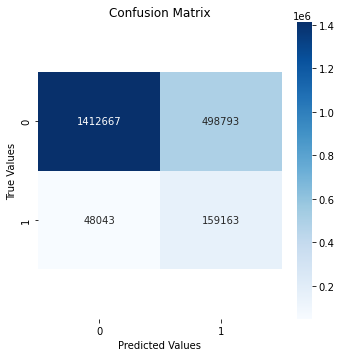

In [20]:
print ("\n Classification report : \n",classification_report (y_test, predictions))
print ("Accuracy   Score : ",accuracy_score (y_test, predictions))

#Generate confusion-matrix as below
conf_matrix = confusion_matrix (y_test,predictions)
plt.figure (figsize= (12,12))
plt.subplot (221)
sns.heatmap (conf_matrix, annot=True, fmt = "d", cmap='Blues')
b, t = plt.ylim()
plt.ylim (b + 0.5, t - 0.5)
plt.ylabel ('True Values')
plt.title ('Confusion Matrix')
plt.xlabel ('Predicted Values')

#Generate F1-score as below
f1 = f1_score (y_test, predictions)
print ("F1 Score: ", f1)

### Training model on updated dataset, i.e., by removing collinear features.

In [21]:
#Reading the updated dataset pickle file with collinear features removed, into a dataframe.

df_non_collinear = pd.read_pickle (root + 'corr_removed_feature_data.pkl')
df_non_collinear.head()

,user_id,product_id,total_product_orders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,...,std_since_order,total_products_by_user,reorder_propotion_by_user,average_order_size,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,0.900000,1.400000,17.593750,10.0,1.0,1.0,1.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667
1,1,10258,9.0,0.888889,3.333333,19.562500,10.0,1.0,1.0,1.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667
2,1,10326,1.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667
3,1,12427,10.0,0.900000,3.300000,17.593750,10.0,1.0,1.0,1.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667
4,1,13032,3.0,0.666667,6.333333,21.671875,10.0,1.0,0.0,0.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667


In [22]:
#Reducing dataframe memory consumption for storage management.

df_non_collinear = reduce_mem(df_non_collinear)

Memory usage of properties dataframe is : 3281.319013595581  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  913.2735185623169  MB
This is  27.832512315270936 % of the initial size


In [23]:
df_non_collinear['order_diff'] = df_non_collinear.order_number - df_non_collinear.product_last_bought_order

In [24]:
df_non_collinear.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [25]:
df_non_collinear

,total_product_orders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,order_dow,...,total_products_by_user,reorder_propotion_by_user,average_order_size,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,10.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,11.0,4.0,...,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,1.0
1,9.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,4.0,...,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,1.0
2,1.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,4.0,...,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,6.0
3,10.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,11.0,4.0,...,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,1.0
4,3.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,11.0,4.0,...,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,3.0,0.666504,8.000000,23.328125,12.0,1.0,0.0,0.0,14.0,6.0,...,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,2.0
8474657,1.0,0.000000,8.000000,9.000000,7.0,0.0,0.0,0.0,14.0,6.0,...,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,7.0
8474658,1.0,0.000000,8.000000,30.000000,11.0,0.0,0.0,0.0,14.0,6.0,...,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,3.0
8474659,1.0,0.000000,6.000000,9.000000,7.0,0.0,0.0,0.0,14.0,6.0,...,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,7.0


In [26]:
label_non_collinear = 'reordered'
x_cols_non_collinear = df_non_collinear.columns.drop('reordered')

In [27]:
X = df_non_collinear[x_cols_non_collinear]
y = df_non_collinear[label_non_collinear]

In [28]:
#Splitting the dataset into training and testing data.

X_train, X_test, y_train, y_test = train_test_split (X, y, stratify = y, test_size = 0.25)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(6355995, 50) (6355995,)
(2118666, 50) (2118666,)


In [29]:
D_train = xgb.DMatrix (X_train, label=y_train)
D_test = xgb.DMatrix (X_test, label=y_test)

C:\Users\hmitt\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [30]:
#Training the model.

watchlist = [(D_train, "train")]
model = xgb.train (params=xgb_params, dtrain=D_train,  evals = watchlist, num_boost_round = 80, verbose_eval = 10)

[0]	train-logloss:0.66547
[10]	train-logloss:0.55455
[20]	train-logloss:0.53366
[30]	train-logloss:0.52790
[40]	train-logloss:0.52528
[50]	train-logloss:0.52405
[60]	train-logloss:0.52308
[70]	train-logloss:0.52228
[79]	train-logloss:0.52178


In [31]:
probability = model.predict (D_test)

In [32]:
#Classifying output variable as 0 and 1 as per threshold value of 0.5

predictions = [1 if i > 0.5 else 0 for i in probability]


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.97      0.74      0.84   1911460
         1.0       0.24      0.77      0.37    207206

    accuracy                           0.74   2118666
   macro avg       0.60      0.75      0.60   2118666
weighted avg       0.90      0.74      0.79   2118666

Accuracy   Score :  0.7415293396882755
F1 Score:  0.3677568253741011


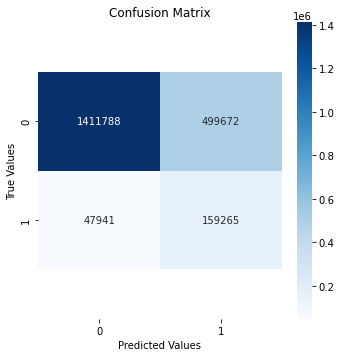

In [33]:
print ("\n Classification report : \n",classification_report (y_test, predictions))
print ("Accuracy   Score : ",accuracy_score (y_test, predictions))

#Generate confusion-matrix as below
conf_matrix = confusion_matrix (y_test,predictions)
plt.figure (figsize=(12,12))
plt.subplot (221)
sns.heatmap (conf_matrix, fmt = "d", annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim (b + 0.5, t - 0.5)
plt.ylabel ('True Values')
plt.title ('Confusion Matrix')
plt.xlabel ('Predicted Values')

#Generate F1-score as below
f1 = f1_score (y_test, predictions)
print ("F1 Score: ", f1)